In [25]:
# Importing and downloading all necessary packages that deals with 
# NLTK and VADER

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

import nltk as nltk
from nltk.corpus import stopwords

import re, gensim

from nltk.classify import NaiveBayesClassifier
import nltk as nltk
nltk.download('subjectivity')
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import * 

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
from nltk import tokenize
nltk.download('vader_lexicon')
nltk.download("stopwords")
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk import tokenize
analyzer = SentimentIntensityAnalyzer()

from nltk.corpus import stopwords

from collections import Counter
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from pprint import pprint


[nltk_data] Downloading package subjectivity to
[nltk_data]     /Users/brettevans/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brettevans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brettevans/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brettevans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# We use the Pandas library to read the contents of the scraped data
df = pd.read_csv('Wingate_by_Wyndham_Atlanta_Buckhead-Atlanta_Georgia__en.csv', encoding='utf-8')
 
# Now we remove duplicate rows (reviews)
df.drop_duplicates(inplace=True)
df.head(5)
    

,Review,Review_Date,Review_Rating
0,We have spent a couple of weeks touring round ...,"November 24, 2018",5
1,In town for Ed Sheeran concert. Room very good...,"November 17, 2018",4
2,Our room was large and clean with an excellent...,"November 12, 2018",5
3,The hotel is located in a very busy street of ...,"November 7, 2018",4
4,Wingate is great for several reasons. I partic...,"November 6, 2018",5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 0 to 2429
Data columns (total 3 columns):
Review           2430 non-null object
Review_Date      2430 non-null object
Review_Rating    2430 non-null int64
dtypes: int64(1), object(2)
memory usage: 75.9+ KB


In [8]:
df.describe()

,Review_Rating
count,2430.000000
mean,4.564609
std,0.785143
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
# To get the length of each review
df['Review_Length'] = df['Review'].apply(len)
df.head()

,Review,Review_Date,Review_Rating,Review_Length
0,We have spent a couple of weeks touring round ...,"November 24, 2018",5,617
1,In town for Ed Sheeran concert. Room very good...,"November 17, 2018",4,308
2,Our room was large and clean with an excellent...,"November 12, 2018",5,638
3,The hotel is located in a very busy street of ...,"November 7, 2018",4,2174
4,Wingate is great for several reasons. I partic...,"November 6, 2018",5,777


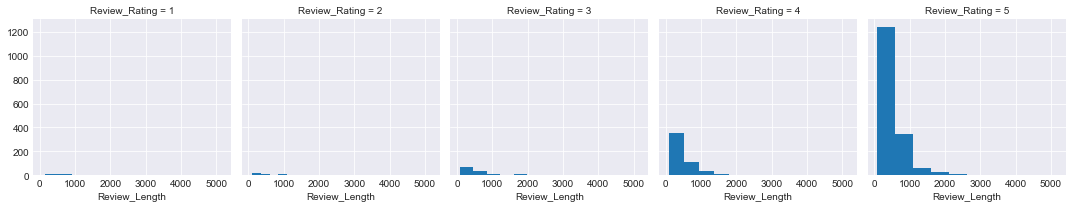

In [21]:
# Checking the relationship between Review Rating and length of the text
g = sns.FacetGrid(data=df, col='Review_Rating')
g.map(plt.hist, 'Review_Length', bins=10)
plt.show()

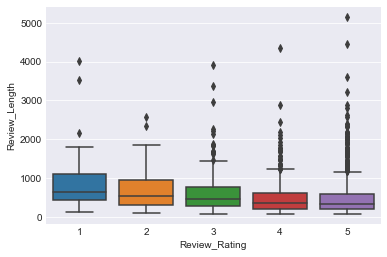

In [11]:
# Box Plot of the text length for each rating
sns.boxplot(x='Review_Rating', y='Review_Length', data=df)
plt.show()

From the above box plot, we notice that rating 1 has the longest reviews followed by reviews with a rating of 2 and then 3. Ratings 4 and 5 have similar lengths. 
We also notice that there are a lot of outliers in reviews with 3, 4 and 5 rating. 

In [12]:
# Instantiate the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [13]:
vader_score = []
#Assign Vader score to individual review using Vader compound score
for rownum, Review in enumerate(df['Review']):
    scores = sid.polarity_scores(Review)
    vader_score.append(scores['compound'])
    if (rownum % 1000 == 0):
            print("processed %d Reviews" % (rownum+1))
print("*******Completed*******")

processed 1 Reviews
processed 1001 Reviews
processed 2001 Reviews
*******Completed*******


In [17]:
# Assign vader scores in the original df
hotelDf = df.assign(Vader_Score = vader_score)
hotelDf.head(10)

,Review,Review_Date,Review_Rating,Review_Length,Vader_Score
0,We have spent a couple of weeks touring round ...,"November 24, 2018",5,617,0.9911
1,In town for Ed Sheeran concert. Room very good...,"November 17, 2018",4,308,0.9780
2,Our room was large and clean with an excellent...,"November 12, 2018",5,638,0.9721
3,The hotel is located in a very busy street of ...,"November 7, 2018",4,2174,0.9877
4,Wingate is great for several reasons. I partic...,"November 6, 2018",5,777,0.9699
5,I found this hotel on Hotelstonight.com at the...,"October 29, 2018",4,484,0.9422
6,"The hotel is on a main road, which is good for...","October 26, 2018",4,999,0.9772
7,I wanted to pass along some information from m...,"October 25, 2018",1,731,-0.6608
8,"Marquis Davis was the ""Host Extraodinaire"" for...","October 17, 2018",5,329,0.7592
9,Coming From New York I found the southern hosp...,"October 17, 2018",4,171,0.8980


In [15]:
'''
Checking if word frequency in review data can tell us how the customers felt 
about their hotel stay.

Getting the most frequently observed words from the positive reviews and negative
reviews, to see if there is any difference.
'''
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    if stopwords:
        temp = []
        for rev in df.Review.unique():
            for token in rev.split():
                if len(token) > 1:
                    temp.append(token)
        my_stop_words = ENGLISH_STOP_WORDS.union(temp)
        vectorizer = CountVectorizer(ngram_range=ngram_range, 
                                     stop_words=my_stop_words, max_features=500)
        
    else:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None, max_features=k)
        
    countvector = vectorizer.fit_transform(df['Review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

In [27]:
#Printing the top 10 words with high frequency in positive and negative reviews

topkTotal = get_topk_ngram(hotelDf, k=500)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=500)
topkPos = get_topk_ngram(hotelDf.loc[df['Review_Rating']==5], 
                         ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['Review_Rating']==1], 
                         ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['Review_Rating']==5], 
                                ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['Review_Rating']==1], 
                                ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

The most frequently occured top 10 words in positive reviews
      Word  Count
0  anthony    105
1  monique    103
2       ve    101
3     didn     90
4      don     79
5    chris     72
6    craig     65
7    marie     56
8   couldn     51
9       ll     39

The most frequently occured top 10 words in negative reviews
           Word  Count
0          didn     13
1          wasn      7
2            ve      6
3       monique      4
4   tripadvisor      4
5  housekeeping      4
6       etienne      4
7            00      4
8      saturday      3
9        wouldn      3

The most frequently occured top 10 bigrams in positive reviews
              Word  Count
0            wi fi     27
1    anthony hines     15
2      hines tecoy     15
3    monique chris     11
4        ben craig      9
5    chris monique      9
6    monique marie      9
7            ve ve      8
8  anthony anthony      7
9     ritz carlton      7

The most frequently occured top 10 bigrams in negative reviews
            

In [38]:
topkNeu= get_topk_ngram(hotelDf.loc[hotelDf['Review_Rating']==3], 
                                 ngram_range=(0,20), k=10, with_count=True)

print("The most frequently occured top 10 words in neutral reviews")
pprint(pd.DataFrame(topkNeu, columns=['Word', 'Count']))


The most frequently occured top 10 words in neutral reviews
            Word  Count
0                   857
1           didn     40
2        atlanta     31
3           wasn     15
4            don     14
5             tv      9
6             00      9
7         couldn      9
8         friday      8
9  disappointing      6


In [28]:
"""
Initialize 4 lists
vader_score: Contains compound score for each Review adjusted for #of sentences
pos_freq: contains the ratios of positive compound scores in each review
neg_freq: contains the ratios of negative compound scores in each review
neut_freq: contains the ratios of neutral compound scores in each review

Where pos,neg, and neut variables are defined by an equal division of the range: [-1,1]
We will append all scores to be the same order as the Review list 
"""

vader_score = []
pos_freq = []
neg_freq = []
neut_freq = []
for i in range(0,len(df.Review)):
    sentence_list=tokenize.sent_tokenize(df.Review[i])
    paragraphSentiments = 0.0
    pos = 0
    neg = 0
    neut = 0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        paragraphSentiments +=vs["compound"]
        if vs["compound"] < -.33333:
            neg += 1
        elif vs["compound"] >.33333:
            pos += 1
        else:
            neut +=1
    vader_score.append(paragraphSentiments/len(sentence_list))
    pos_freq.append(pos/len(sentence_list))
    neg_freq.append(neg/len(sentence_list))
    neut_freq.append(neut/len(sentence_list))

In [29]:
"""
Since all 4 lists are in the same order, we are able to stack them
into columns of a new dataframe called dfVader
"""

dfVader = pd.DataFrame(np.column_stack([df.Review,vader_score,pos_freq,neg_freq,neut_freq]),
                       columns=["Review","Vader_Score","pos_freq","neg_freq","neut_freq"])
dfVader.head()

,Review,Vader_Score,pos_freq,neg_freq,neut_freq
0,We have spent a couple of weeks touring round ...,0.8885,1,0,0
1,In town for Ed Sheeran concert. Room very good...,0.372075,0.5,0,0.5
2,Our room was large and clean with an excellent...,0.38958,0.6,0,0.4
3,The hotel is located in a very busy street of ...,0.208813,0.4,0.0666667,0.533333
4,Wingate is great for several reasons. I partic...,0.433878,0.777778,0.111111,0.111111


(array([  1.,   1.,   1.,   0.,   0.,   2.,   1.,   0.,   2.,   3.,   2.,
          5.,   2.,   7.,   3.,  13.,  15.,  20.,  15.,  28.,  25.,  44.,
         35.,  45.,  48.,  70.,  96.,  90., 114., 126., 136., 180., 166.,
        158., 166., 140., 117., 109., 102.,  73.,  71.,  58.,  30.,  23.,
         21.,  15.,  12.,  12.,  20.,   7.]),
 array([-0.6486 , -0.61572, -0.58284, -0.54996, -0.51708, -0.4842 ,
        -0.45132, -0.41844, -0.38556, -0.35268, -0.3198 , -0.28692,
        -0.25404, -0.22116, -0.18828, -0.1554 , -0.12252, -0.08964,
        -0.05676, -0.02388,  0.009  ,  0.04188,  0.07476,  0.10764,
         0.14052,  0.1734 ,  0.20628,  0.23916,  0.27204,  0.30492,
         0.3378 ,  0.37068,  0.40356,  0.43644,  0.46932,  0.5022 ,
         0.53508,  0.56796,  0.60084,  0.63372,  0.6666 ,  0.69948,
         0.73236,  0.76524,  0.79812,  0.831  ,  0.86388,  0.89676,
         0.92964,  0.96252,  0.9954 ]),
 <a list of 50 Patch objects>)

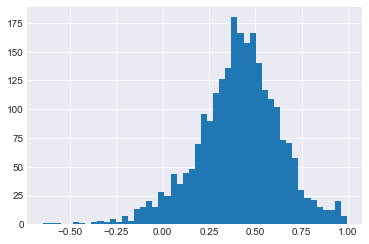

In [30]:
#Distribution of all vader_scores that we collected
plt.hist(vader_score, bins = 50)

In [31]:
#converting each score to float
dfVader['Vader_Score']=dfVader['Vader_Score'].astype(float)
dfVader['pos_freq']=dfVader['pos_freq'].astype(float)
dfVader['neg_freq']=dfVader['neg_freq'].astype(float)
dfVader['neut_freq']=dfVader['neut_freq'].astype(float)

In [32]:
dfVader.head(5)
#dfVader[(dfVader['Vader_Score'] < 0) &(dfVader['pos_freq'] > 0)]

,Review,Vader_Score,pos_freq,neg_freq,neut_freq
0,We have spent a couple of weeks touring round ...,0.888500,1.000000,0.000000,0.000000
1,In town for Ed Sheeran concert. Room very good...,0.372075,0.500000,0.000000,0.500000
2,Our room was large and clean with an excellent...,0.389580,0.600000,0.000000,0.400000
3,The hotel is located in a very busy street of ...,0.208813,0.400000,0.066667,0.533333
4,Wingate is great for several reasons. I partic...,0.433878,0.777778,0.111111,0.111111


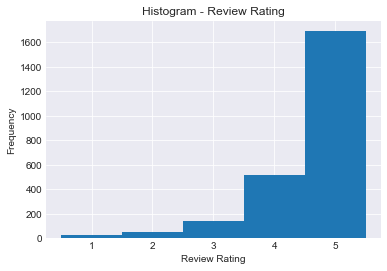

In [33]:
# Plotting the actual ratings verses the vader score
plt.xlabel('Review Rating')
hotelDf['Review_Rating'].plot(kind='hist', title='Histogram - Review Rating',
                            bins=np.arange(1,7)-0.5)
plt.show()

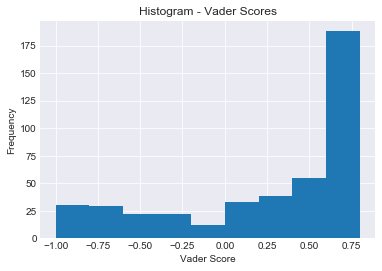

In [34]:
# Plotting the histogram for Vader Scores
plt.xlabel('Vader Score')
hotelDf['Vader_Score'].plot(kind='hist', title='Histogram - Vader Scores',
                            bins=np.arange(-1,1,0.2))
plt.show()

/Users/brettevans/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/brettevans/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


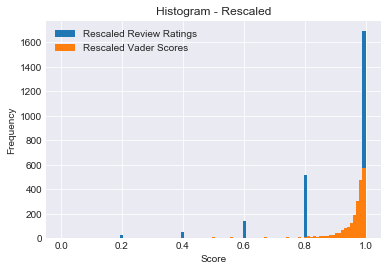

In [23]:
'''
Overlayed Histogram for Review rating and Vader score
Just for demonstrating, I am dividing the rating score by 5
'''
x = [hotelDf['Review_Rating'].as_matrix() / 5]
y = [(hotelDf['Vader_Score'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled Review Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

In [32]:
DataFrame.shape('hotelDf')

NameError: name 'DataFrame' is not defined